<p style="color:red">
NOTEBOOK LAST EDITED ON: 20230323    
</p>

----
# RLCT Estimates for One Hidden Layer Tanh Model
----
In this notebook, we document a method used to estimate RLCT following Theorem 4 of the WBIC paper: 
```
Watanabe, Sumio. 2013. “A Widely Applicable Bayesian Information Criterion.” Journal of Machine Learning Research: JMLR 14 (Mar): 867–97.
```

## Brief theory
Given a model $p(x \mid w)$, prior $\varphi(w)$ and dataset $D_n = \{X_i: i = 1, \dots, n\}$ drawn i.i.d. from a true distribution $q(x)$, the theorem assert that for an empirical negative log-likelihood function $L_n(w) = -1/n \sum_i \log p(X_i \mid w)$ satisfies the following asymptotic expansion in $n$
$$
\mathbb{E}_{w}^\beta[n L_n(w)] = n L_n(w_0) + \frac{\lambda}{\beta} + U_n \sqrt{\frac{\lambda}{\beta}} + O_p(1)
$$
where 
  * $\mathbb{E}_w^{\beta}[]$ is expectation over the tempered posterior distribution with inverse temperature $\beta$, 
    $$
    p(w \mid D_n) \propto \varphi(w) \prod_{i} p(X_i \mid w)^\beta = \varphi(w) e^{-\beta n L_n(w)}
    $$
  * the inverse temperature is chosen at $\beta = \beta_0 / \log n$ for some constant $\beta_0$. 
  * $w_0$ is global minima of the averaged log-likelihood function $L(w) = -\int q(x) \log p(x \mid w) dx$. 
  * $\lambda$ is the learning coefficient or the RLCT of the zero set of $L(w) - L(w_0)$. 

Hence, for large enough $n$, we expect linear regression for a set of points $(1/ \beta, \mathbb{E}_{w}^\beta[n L_n(w)])$ would result with intercept and slope that could estimate $nL_n(w_0)$ and $\lambda$. 

## Implementation
We will implement the probability model and MCMC sampling in [numpyro](https://num.pyro.ai/en/stable/index.html). 


In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, BarkerMH

In [2]:
ACTIVATION_FUNC_SWITCH = {
    "tanh": jnp.tanh, 
    "id": lambda x: x, 
    "relu": lambda x: jnp.maximum(0, x), 
}

XMIN, XMAX = -2, 2

class OneLayerTanhModel(object):
    
    def __init__(
        self, 
        true_param_dict, 
        num_training_samples=10, 
        input_dim=1, 
        output_dim=1,
        num_hidden_nodes=1, 
        itemp=1.0,
        sigma=1.0, 
        prior_name="normal", 
        activation_func_name="tanh",
        prior_sigma=1.0
    ):
        self.true_param_dict = true_param_dict
        self.num_hidden_nodes = num_hidden_nodes
        self.num_training_samples = num_training_samples
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # this is used as standard deviation of the noise 
        # of the data generating distribution as well as the observation noise. 
        self.sigma = sigma  
        self.itemp=itemp
        self.prior_name = prior_name
        
        if self.prior_name.lower() == "uniform":
            self.w1_prior = dist.Uniform(
                low=-jnp.ones((self.input_dim, self.num_hidden_nodes)), 
                high=jnp.ones((self.input_dim, self.num_hidden_nodes))
            )
            self.w2_prior = dist.Uniform(
                low=-jnp.ones((self.num_hidden_nodes, self.output_dim)), 
                high=jnp.ones((self.num_hidden_nodes, self.output_dim))
            )
        elif self.prior_name.lower() == "normal":
            self.w1_prior = dist.Normal(
                jnp.zeros((self.input_dim, self.num_hidden_nodes)), 
                jnp.ones((self.input_dim, self.num_hidden_nodes)) * prior_sigma
            )
            self.w2_prior = dist.Normal(
                jnp.zeros((self.num_hidden_nodes, self.output_dim)), 
                jnp.ones((self.num_hidden_nodes, self.output_dim)) * prior_sigma
            )
        
        self.activation_func = ACTIVATION_FUNC_SWITCH[activation_func_name]
        self.X, self.Y = self.generate_data(num_training_samples)        
        self.rng_key, self.rng_key_predict = random.split(random.PRNGKey(0))
        
        
    def regression_func(self, X, param_dict):
        W1 = param_dict["W1"]
        W2 = param_dict["W2"]
        return jnp.matmul(self.activation_func(jnp.matmul(X, W2)), W1)
    
    def expected_nll(self, param_dict):
        y_hat = self.regression_func(self.X, param_dict)
        ydist = dist.Normal(y_hat, self.sigma)
        nll = -ydist.log_prob(self.Y).sum()
        return nll
    
    def model(self, X, Y, itemp=None):
        param_dict = {
            "W1": numpyro.sample("W1", self.w1_prior),
            "W2": numpyro.sample("W2", self.w2_prior)
        }
        y_hat = self.regression_func(X, param_dict)
        if itemp is None:
            itemp = self.itemp
        with numpyro.plate("data", X.shape[0]):
            # Notice that the inverse temperature `itemp` is specified as modifcation 
            # of the observation noise. 
            numpyro.sample("Y", dist.Normal(y_hat, self.sigma / np.sqrt(itemp)).to_event(1), obs=Y)
        return
    
    def generate_data(self, num_training_samples):
        """
        Generate `num_training_samples` amount of data for the 
        specified network with true parameter given by `self.true_param_dict`. 
        """
        X = (XMAX - XMIN) * np.random.rand(num_training_samples, self.input_dim) + XMIN
        Y = self.regression_func(X, self.true_param_dict)
        Y += self.sigma * np.random.randn(*Y.shape)
        return X, Y

    def run_inference(
        self, 
        num_warmup, 
        num_posterior_samples, 
        num_chains, 
        thinning=1, 
        print_summary=False, 
        progress_bar=False, 
        itemp=None
    ):
        """
        Run MCMC sampling using NUTS sampler at a specfied 
        inverse temperature `itemp`. 
        """
        start = time.time()
        kernel = NUTS(self.model)
        self.mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_posterior_samples,
            num_chains=num_chains,
            thinning=thinning, 
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else progress_bar,
        )
        self.mcmc.run(
            self.rng_key, 
            self.X, 
            self.Y, 
            itemp=itemp,
        )
        if print_summary:
            self.mcmc.print_summary()
            print("\nMCMC elapsed time:", time.time() - start)
        return self.mcmc.get_samples()
    
    def predict(self, posterior_samples, X):
        def _helper(rng_key, posterior_samples, X):
            model = handlers.substitute(handlers.seed(self.model, rng_key), posterior_samples)
            # note that Y will be sampled in the model because we pass Y=None here
            model_trace = handlers.trace(model).get_trace(X=X, Y=None)
            return model_trace["Y"]["value"]
        num_posterior_samples = self.mcmc.get_samples()["W1"].shape[0]
        vmap_args = (
            posterior_samples,
            random.split(self.rng_key_predict, num_posterior_samples),
        )
        predictions = vmap(
            lambda samples, rng_key: _helper(rng_key, samples, X)
        )(*vmap_args)
        return predictions
    
    
    def true_rlct(self):
        rlct_one_hidden_layer_tanh(self.num_hidden_nodes)

def rlct_one_hidden_layer_tanh(num_hidden_nodes):
    """
    RLCT of 1-Hidden Layer Tanh network when the true regression function 
    is the zero function. 
    Reference: 
    """
    h = int(num_hidden_nodes ** 0.5)
    H = num_hidden_nodes
    return (H + h * h + h) / (4 * h + 2)    

In [6]:
for x in range(1, 10):
    print(f"h = {x}, RLCT={rlct_one_hidden_layer_tanh(x):.2f}")

h = 1, RLCT=0.50
h = 2, RLCT=0.67
h = 3, RLCT=0.83
h = 4, RLCT=1.00
h = 5, RLCT=1.10
h = 6, RLCT=1.20
h = 7, RLCT=1.30
h = 8, RLCT=1.40
h = 9, RLCT=1.50


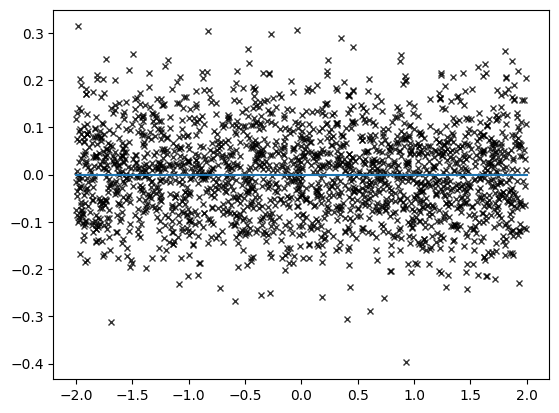

In [3]:
true_param_dict = {
    "W1": jnp.array([[0.0]]),
    "W2": jnp.array([[0.0]]).T
}
input_dim, num_hidden_nodes = true_param_dict["W1"].shape
output_dim = true_param_dict["W2"].shape[1]
num_training_samples = 2023
one_layer_tanh = OneLayerTanhModel(
    true_param_dict, 
    num_training_samples=num_training_samples,
    input_dim=input_dim, 
    output_dim=output_dim,
    num_hidden_nodes=num_hidden_nodes,
    sigma=0.1, 
    itemp=1.0, 
    prior_name="normal", 
    activation_func_name="tanh", 
    prior_sigma=1.0
)

plt.plot(one_layer_tanh.X, one_layer_tanh.Y, "kx", markersize=5, alpha=0.8);
a = np.linspace(XMIN, XMAX, num=50)[:, np.newaxis]
plt.plot(a, one_layer_tanh.regression_func(a, true_param_dict));

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_91696/2824723391.py:111: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(
sample: 100%|████████████████████████████████████████████| 2500/2500 [00:01<00:00, 2206.38it/s, 3 steps of size 3.78e-02. acc. prob=0.94]


Expected nll -1854.44


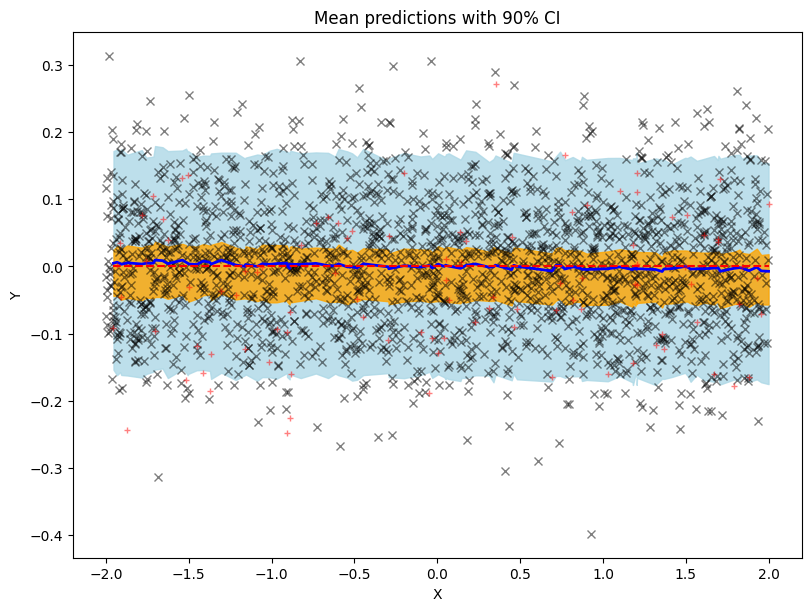

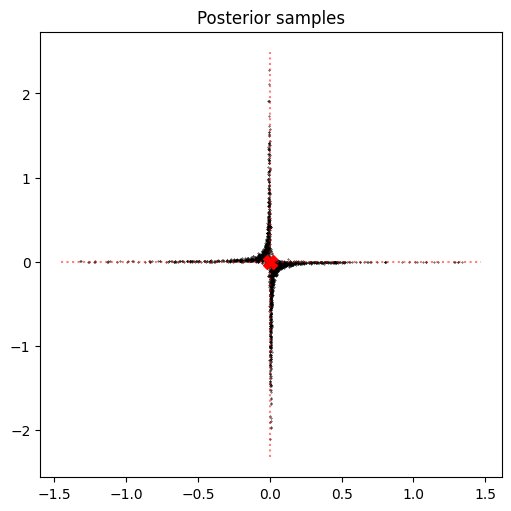

In [4]:
posterior_samples = one_layer_tanh.run_inference(
    num_warmup=500, 
    num_posterior_samples=2000,
    num_chains=4,
    thinning=4,
    progress_bar=True, 
    itemp=1.0 #1 / np.log(one_layer_tanh.num_training_samples)
)

X_test, Y_test = one_layer_tanh.generate_data(100)

sort_index = np.argsort(X_test[:, 0])
X_test = X_test[sort_index]
Y_test = Y_test[sort_index]

preds = one_layer_tanh.predict(posterior_samples, X_test)[..., 0] # shape = (posterior, test, )
mean_prediction = jnp.mean(preds, axis=0)
percentiles = np.percentile(preds, [5.0, 95.0], axis=0)
percentiles2 = np.percentile(preds, [30.0, 60.0], axis=0)


# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(one_layer_tanh.X, one_layer_tanh.Y, "kx", alpha=0.5)
# plot 90% confidence level of predictions
ax.fill_between(X_test[:, 0], percentiles[0, :], percentiles[1, :], color="lightblue", alpha=0.8)
ax.fill_between(X_test[:, 0], percentiles2[0, :], percentiles2[1, :], color="orange", alpha=0.8)

# plot mean prediction
ax.plot(X_test[:, 0], mean_prediction, color="blue", ls="solid", lw=2.0)
ax.plot(X_test[:, 0], Y_test[:, 0], "r+", markersize=5, alpha=0.5)
ax.plot(X_test[:, 0], one_layer_tanh.regression_func(X_test, true_param_dict), "r--")
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");


# a = np.linspace(-1, 1, num=50)[:, np.newaxis]
# ax.plot(a, one_layer_tanh.regression_func(a, true_param_dict), color="r")
# preds[0][0]

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

i1, i2 = 0, 0
j1, j2 = 0, 0
ax.plot(posterior_samples["W1"][:, i1, i2], posterior_samples["W2"][:, j1, j2], "kx", markersize=1, alpha=0.5)
ax.plot([true_param_dict["W1"][i1, i2]], [true_param_dict["W2"][j1, j2]], "rX", markersize=10)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')
ax.set_title("Posterior samples");

nlls = []
num_mcmc_samples = len(posterior_samples[list(posterior_samples.keys())[0]])
for i in range(num_mcmc_samples):
    param_dict = {name: param[i] for name, param in posterior_samples.items()}
    nlls.append(one_layer_tanh.expected_nll(param_dict))

enll = np.mean(nlls)
print(f"Expected nll {enll:.2f}")

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


itemps=[0.09769843 0.10518004 0.11266166 0.12014328 0.1276249  0.13510651
 0.14258813 0.15006975 0.15755137 0.16503298]


sample: 100%|███████████████████████████████████████████| 3000/3000 [00:00<00:00, 5954.87it/s, 13 steps of size 1.36e-01. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.09769842750203417. Expected NLL=-1758.1123046875


sample: 100%|███████████████████████████████████████████| 3000/3000 [00:00<00:00, 6139.90it/s, 11 steps of size 1.48e-01. acc. prob=0.88]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.1051800448606579. Expected NLL=-1758.7340087890625


sample: 100%|███████████████████████████████████████████| 3000/3000 [00:00<00:00, 6137.12it/s, 11 steps of size 1.14e-01. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.11266166221928163. Expected NLL=-1759.2696533203125


sample: 100%|███████████████████████████████████████████| 3000/3000 [00:00<00:00, 6203.39it/s, 11 steps of size 1.06e-01. acc. prob=0.91]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.12014327957790537. Expected NLL=-1759.6612548828125


sample: 100%|████████████████████████████████████████████| 3000/3000 [00:00<00:00, 5844.22it/s, 3 steps of size 1.18e-01. acc. prob=0.91]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.1276248969365291. Expected NLL=-1760.318115234375


sample: 100%|███████████████████████████████████████████| 3000/3000 [00:00<00:00, 6192.63it/s, 11 steps of size 1.28e-01. acc. prob=0.88]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.13510651429515283. Expected NLL=-1760.7034912109375


sample: 100%|████████████████████████████████████████████| 3000/3000 [00:00<00:00, 6074.26it/s, 3 steps of size 1.28e-01. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.14258813165377657. Expected NLL=-1761.0994873046875


sample: 100%|████████████████████████████████████████████| 3000/3000 [00:00<00:00, 6091.05it/s, 3 steps of size 1.17e-01. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.15006974901240028. Expected NLL=-1761.5142822265625


sample: 100%|████████████████████████████████████████████| 3000/3000 [00:00<00:00, 6046.62it/s, 3 steps of size 1.49e-01. acc. prob=0.87]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_36208/2363176644.py:103: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


Finished itemp=0.15755136637102402. Expected NLL=-1761.7828369140625


sample: 100%|███████████████████████████████████████████| 3000/3000 [00:00<00:00, 6109.48it/s, 11 steps of size 1.46e-01. acc. prob=0.91]


Finished itemp=0.16503298372964775. Expected NLL=-1761.927490234375


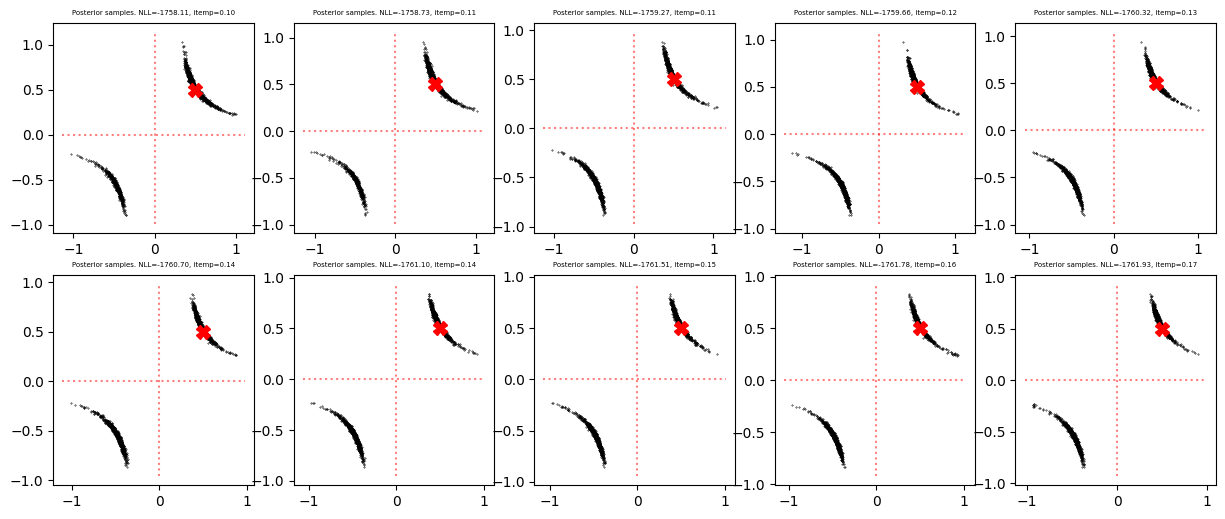

In [7]:
num_itemps = 10
n = one_layer_tanh.num_training_samples
itemps = np.linspace(
    1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
    1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), 
    num_itemps
)

# itemps = np.linspace(1 / np.log(n), 1.5 / np.log(n), num=num_itemps)
# itemps = np.array(list(itemps) + [1.0, 2.0, 5.0, 15.0])
# itemps = np.array([0.1, 0.2, 0.3, 0.5])
print(f"itemps={itemps}")

num_rows = 2
num_cols = len(itemps) // num_rows + (len(itemps) % num_rows != 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
axes = np.ravel(axes)
enlls = []
for i, itemp in enumerate(itemps):
    ax = axes[i]
    posterior_samples = one_layer_tanh.run_inference(
        num_warmup=1000, 
        num_posterior_samples=2000,
        num_chains=4,
        thinning=4,
        progress_bar=True, 
        itemp=itemp
    )
    nlls = []
    num_mcmc_samples = len(posterior_samples[list(posterior_samples.keys())[0]])
    for i in range(num_mcmc_samples):
        param_dict = {name: param[i] for name, param in posterior_samples.items()}
        nlls.append(one_layer_tanh.expected_nll(param_dict))

    enll = np.mean(nlls)
    enlls.append(enll)
    print(f"Finished itemp={itemp}. Expected NLL={enll}")
    
    i1, i2 = 0, 0
    j1, j2 = 0, 0
    ax.plot(posterior_samples["W1"][:, i1, i2], posterior_samples["W2"][:, j1, j2], "kx", markersize=1, alpha=0.5)
    ax.plot([true_param_dict["W1"][i1, i2]], [true_param_dict["W2"][j1, j2]], "rX", markersize=10)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
    ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')
    ax.set_title(f"Posterior samples. NLL={enll:.2f}, itemp={itemp:.2f}", fontdict={"fontsize": 5});


R^2=0.9961710815684908


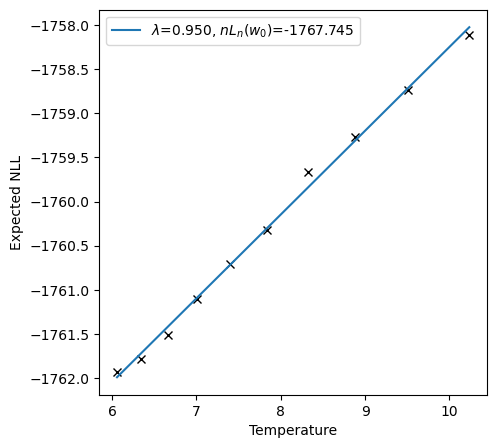

In [8]:
import scipy

fig, ax = plt.subplots(figsize=(5,5))


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
ax.plot(1/itemps, enlls, "kx")
ax.plot(1/itemps, 1/itemps * slope + intercept, label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}")
print(f"R^2={r_val**2}")


# slope, intercept, r_val, p_val, _ = scipy.stats.linregress(1 / itemps[:num_itemps], enlls[:num_itemps])
# ax.plot(1/itemps[:num_itemps], enlls[:num_itemps], "kx")
# ax.plot(
#     1/itemps[:num_itemps], 
#     1/itemps[:num_itemps] * slope + intercept, 
#     label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}"
# )
# print(f"R^2={r_val**2}, p_val={p_val}")


# slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[num_itemps:], enlls[num_itemps:])
# ax.plot(1/itemps[num_itemps:], enlls[num_itemps:], "kx")
# ax.plot(
#     1/itemps[num_itemps:], 
#     1/itemps[num_itemps:] * slope + intercept, 
#     label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}"
# )
# print(f"R^2={r_val**2}")

ax.legend()
ax.set_xlabel("Temperature")
ax.set_ylabel("Expected NLL");

